## **Project2：特徵重要性計算 (Feature Importance)**

### **動機**

在量化交易策略的開發過程中，金融市場資料常包含大量技術指標與衍生特徵，若直接將所有特徵丟入機器學習模型，容易造成過度擬合、運算成本過高，且不易洞察哪些特徵對預測最具貢獻。  
本專案旨在針對多樣化的技術指標與統計特徵，透過多種特徵重要性方法（MDI、MDA、SFI）進行評估，篩選出對後續 Meta-Labeling 或其他模型訓練最具代表性的特徵子集。

---

### **流程概述**

1. **資料讀取與事件生成**  
   - 讀取 Project1 產生的分群結果。  
   - 將原始的多商品價格資料（Dollar Bars）與對應事件整合，確保「事件時間區間」與「標籤（Label）」可供後續特徵計算使用。

2. **技術指標與特徵工程**  
   - 對每段事件存續期間，以及其觸發前後指定的回溯窗口，計算多種技術指標（如 RSI、ATR、SMA、EMA、布林通道、成交量相關指標等）。  
   - 對非平穩指標進行Fraction Difference，平穩化指標的同時讓指標保持記憶性。
   - 使用PCA移除特徵間的共線性，以此降低特徵間的substition effect。

3. **切分訓練與驗證資料**  
   - 依據時間順序，將事件資料按「Purged K-Fold Cross-Validation」原則進行切分，以避免資料洩漏：  
     1. 首先以時間區間（例如年份）做粗略切分；  
     2. 在每個摺疊（Fold）內摒棄與測試集事件存續期間有交集的訓練事件（Purging）；  
     3. 用唯一性(uniqueness)進一步平衡樣本權重。  
   - 最終產生多組 Train / Validation 折疊，用於特徵重要性計算。

4. **計算特徵重要性**  
   - **MDI（Mean Decrease in Impurity）**：  
     - 以隨機森林（Random Forest）模型擬合訓練集，根據每棵決策樹的節點分裂所減少的Entropy，累計至每個特徵。  
   - **MDA（Mean Decrease in Accuracy，Permutation Importance）**：  
     - 在驗證集上，逐一打亂每個特徵的取值（Permutation），觀察模型預測準確度的下降幅度。下降越多，代表該特徵對模型性能貢獻越大。  
   - **SFI（Single Feature Importance）**：  
     - 單獨僅使用某個特徵訓練模型，評估其在驗證集上的分類效果，排名特徵的預測能力。

5. **結果可視化與輸出**  
   - 繪製各特徵方法的排名條形圖（Bar Chart）。  
   - 最終以 CSV 檔形式輸出`mdi.csv` `mda.csv` `sfi.csv`。。

---

### **核心特色說明**

- **Purged K-Fold Cross-Validation**  
  - 為避免事件期間與測試集重疊造成資料洩漏，每個摺疊會刪除掉與測試時段相重疊的訓練事件。  
  - 根據《Advances in Financial Machine Learning》建議，先將事件按時間切分，再剔除重疊範圍，確保不會偷看到未來資料。

- **Fractional Differentiation (FFD)**  
  - 傳統的差分 (integer differencing) 可能過度去除序列長期記憶性，使得部分潛在訊號流失。FFD 提供一種「非整數階差分」的方式，透過逐步逼近法，根據最小化自相關與 ADF 單根檢定結果，選擇最佳差分階數。  
  - FFD 的優點在於：  
    1. **保留長期記憶性 (Long Memory)**：避免完全消除序列的自相關結構；  
    2. **平穩化（Stationarize）**：將非平穩序列轉為近似平穩，符合大多回歸模型與機器學習對輸入特徵的假設；  
    3. **減少信息損失**：相較於 Integer Differencing，可保留更多序列原始波動信息。  

- **PCA 移除共線性**  
  - 金融技術指標之間往往高度相關，若直接投入模型訓練，容易因替代現象 (Substitution Effect) 造成某些變量重要度被高估。  
  - 使用 PCA（Principal Component Analysis）提取主要成分，保留 > 95% 變異量，同時降低維度，有助於後續特徵重要性計算更穩定。

- **三種特徵重要性方法**  
  1. **MDI（Mean Decrease in Impurity）**  
     - 透過 Random Forest 訓練時，決策樹分裂節點所減少的 Gini 或 Entropy，作為特徵貢獻值的指標。  
  2. **MDA（Permutation Importance）**  
     - 在驗證集上逐一打亂特徵，觀察模型`neg_log_loss` 的下降量，下降越多則features更有貢獻。  
  3. **SFI（Single Feature Importance）**  
     - 單變數模型訓練，檢視該特徵單獨預測能力，提供最直觀的「單一特徵力量」評估。

---



### **讀取資料**
- 讀取黃金所在群集，並將該集合內資料轉換為dollar bars

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join("..", "QuantCommon"))
if project_root not in sys.path:
    sys.path.append(project_root)

# utils為我自己編寫的常用工具庫，檔案不在此作品集內
from utils.processing import get_dollar_bars 
import numpy as np
import pandas as pd
import numpy as np


clusters = pd.read_csv("results/clusters.csv", index_col=0)
print(f'XAUUSD 在第{clusters.loc["XAUUSD_M1", "cluster"]}群')

group = clusters[clusters["cluster"] == clusters.loc["XAUUSD_M1", "cluster"]]
data = dict({})
for i in group.index:
    print(f"Processing {i[:-3]}...")
    filepath = os.path.join(project_root, "data", "FI", "M1",f"{i}.csv")
    df = pd.read_csv(filepath, parse_dates=True)
    df['time'] = pd.to_datetime(df['time'])
    df = get_dollar_bars(df)
    data[i] = df

XAUUSD 在第1群
Processing AUDUSD...
Processing EURUSD...
Processing GBPUSD...
Processing HK50...
Processing JP225...
Processing NZDUSD...
Processing UK100...
Processing US2000...
Processing USDCAD...
Processing XAGUSD...
Processing XAUUSD...


### **對資料進行labeling和特徵計算**
- 使用trible barrier進行labeling以及計算指標作為特徵

In [2]:
from utils.metalabeling import add_vertical_barrier, get_events, get_bins
from utils.processing import apply_cusum_filter, getDailyVol, cal_weights, compute_talib_features

feats_list, labels_list, weights_list, t1_list = [], [], [], []

for symbol,df in data.items():
    print(f"Processing {symbol[:-3]}...")
    vol = getDailyVol(df["close"], span0=20)
    cusum_events  = apply_cusum_filter(df, volatility=vol).index
    vertical_barriers = add_vertical_barrier(cusum_events, df, num_days=2)
    pt_sl = [1, 1]
    min_ret = 0.003
    triple_barrier_events = get_events(close=df["close"],
                                                t_events=cusum_events,
                                                pt_sl=pt_sl,
                                                target=vol,
                                                min_ret=min_ret,
                                                num_threads=4,
                                                vertical_barrier_times=vertical_barriers,
                                                side_prediction=None)
    labels  = get_bins(triple_barrier_events, df["close"])
    weights = cal_weights(triple_barrier_events, df["close"])
    feats = compute_talib_features(df,
                               periods=[7,28,50,100],
                               apply_ffd=True)
    
    # normalize features
    for col in feats.columns:
        # 每個 col 分別做 rolling.apply
        feats[col] = (
            feats[col]
            .rolling(window=200, min_periods=1)
            .apply(lambda arr: (arr <= arr[-1]).sum() / len(arr), raw=True)
        )
    idx = feats.index.intersection(labels.index)
    feats = feats.loc[idx]
    labels = labels.loc[idx]["bin"]
    weights = weights.loc[idx]["weight"]
    weights = weights / weights.mean() # normalize weights
    t1 = triple_barrier_events.loc[idx]["t1"]

    feats_list.append(feats)
    labels_list.append(labels.rename("bin"))
    weights_list.append(weights.rename("weight"))
    t1_list.append(t1.rename("t1"))

    
feats = pd.concat(feats_list)
labels = pd.concat(labels_list)
weights = pd.concat(weights_list)/len(weights)
t1 = pd.concat(t1_list)

combined_features = pd.concat(
    [feats, labels, weights, t1],
    axis=1
)
combined_features.sort_index(inplace=True)
combined_features.to_csv("intermediate_results/combined_features.csv", index=True)

labels = combined_features['bin']   
weights = combined_features['weight']
t1 = combined_features['t1']
feats = combined_features.drop(columns=['bin', 'weight', 't1'],axis=1)

Processing AUDUSD...
Processing EURUSD...
Processing GBPUSD...
Processing HK50...
Processing JP225...
Processing NZDUSD...
Processing UK100...
Processing US2000...
Processing USDCAD...
Processing XAGUSD...
Processing XAUUSD...


In [3]:
feats.head()

,log_ret,atr_7,bb_width_7,volatility_7,sma_7,ema_7,adx_7,plus_di_7,minus_di_7,dx_7,...,ppo_100,ppo_signal_100,ppo_hist_100,kama_100,willr_100,stoch_k_100,stoch_d_100,obv,adl,sar
time,,,,,,,,,,,,,,,,,,,,,
2015-01-14 03:24:00,0.055,1.00,1.000,0.965,0.075,0.070,1.000,0.035,0.910,1.000,...,0.215,0.675,0.250,0.015,0.090,0.065,0.115,0.025,0.005,0.040
2015-01-15 10:35:00,0.045,1.00,1.000,1.000,0.175,0.180,1.000,0.025,0.980,1.000,...,0.005,0.745,0.010,0.410,0.300,0.200,0.175,0.055,0.115,0.080
2015-01-15 10:36:00,1.000,1.00,0.945,1.000,0.180,0.185,1.000,0.135,0.935,0.955,...,0.010,0.725,0.015,0.410,0.495,0.225,0.170,0.135,0.140,0.085
2015-01-15 10:40:00,0.965,0.95,0.815,1.000,0.200,0.225,0.925,0.200,0.660,0.695,...,0.030,0.235,0.035,0.410,0.650,0.300,0.170,0.335,0.220,0.160
2015-01-16 02:04:00,0.095,0.88,0.910,0.700,0.520,0.485,0.220,0.085,0.930,0.700,...,0.005,0.235,0.080,0.720,0.310,0.700,0.755,0.395,0.155,0.910


### **PCA**

In [4]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# === Pipeline : z-score → PCA ===
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca",    PCA(n_components=0.95, whiten=False)),
])


X = pipe.fit_transform(feats)


In [5]:
from joblib import dump
# 儲存模型
dump(pipe, "models/pipeline_scaler_pca.joblib")


['models/pipeline_scaler_pca.joblib']

### **建立所需function**


- PurgedKFold

In [6]:
import numpy as np
import pandas as pd

class PurgedKFold:
    def __init__(self, n_splits=3, t1=None, pct_embargo=0.0):
        if not isinstance(t1, pd.Series):
            raise ValueError("t1 must be a pandas Series")
        self.n_splits = n_splits
        self.t1 = t1.sort_index()
        self.pct_embargo = pct_embargo

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        if not X.index.equals(self.t1.index):
            raise ValueError("X and t1 must have the same index")
        n_samples = len(X)
        indices = np.arange(n_samples)
        # divide indices into contiguous chunks
        test_slices = np.array_split(indices, self.n_splits)
        mbrg = int(n_samples * self.pct_embargo)

        for slice_ in test_slices:
            i, j = slice_[0], slice_[-1] + 1
            test_idx = indices[i:j]

            # start‐time of test block
            t0 = self.t1.index[i]
            # end‐time of test block
            t1_max = self.t1.iloc[test_idx].max()
            # find the position just after t1_max
            max_t1_pos = self.t1.index.searchsorted(t1_max)

            # training before test block
            train_before = indices[self.t1.index < t0]
            # training after test + embargo
            train_after = indices[max_t1_pos + mbrg :]

            train_idx = np.concatenate([train_before, train_after])
            yield train_idx, test_idx


- CVscore
    - 因sklearn本身的cv score在傳送weights會不一致，需要自己建立function

In [7]:
import numpy as np
from sklearn.base import clone
from sklearn.metrics import log_loss, accuracy_score

def cv_score(clf,
             X,
             y,
             sample_weight=None,
             scoring="neg_log_loss",
             t1=None,
             cv=3,
             pct_embargo=0.01):

    if scoring not in ["neg_log_loss", "accuracy"]:
        raise ValueError('scoring must be "neg_log_loss" or "accuracy"')

    pkf = PurgedKFold(n_splits=cv, t1=t1, pct_embargo=pct_embargo)
    scores = []

    for train_idx, test_idx in pkf.split(X):
        # 複製一份新的 model
        model = clone(clf)
        # fit
        if sample_weight is None:
            model.fit(X.iloc[train_idx], y.iloc[train_idx])
        else:
            model.fit(X.iloc[train_idx],
                      y.iloc[train_idx],
                      sample_weight=sample_weight.iloc[train_idx].values)
        # predict + score
        if scoring == "neg_log_loss":
            prob = model.predict_proba(X.iloc[test_idx])
            sc = -log_loss(y.iloc[test_idx],
                           prob,
                           sample_weight=(None if sample_weight is None else sample_weight.iloc[test_idx].values),
                           labels=model.classes_)
        else:
            pred = model.predict(X.iloc[test_idx])
            sc = accuracy_score(y.iloc[test_idx],
                                pred,
                                sample_weight=(None if sample_weight is None else sample_weight.iloc[test_idx].values))
        scores.append(sc)
    return np.array(scores)





- MDA MDI SFI 

In [8]:
from tqdm import tqdm

# 1) MDI 
def feat_imp_mdi(fit, feat_names):
    # 從每顆樹蒐集 feature_importances_
    df0 = pd.DataFrame(
        [tree.feature_importances_ for tree in fit.estimators_],
        columns=feat_names
    ).replace(0, np.nan)  # 如果 max_features=1，某些 tree 有 0
    imp = pd.concat({
        "mean": df0.mean(),
        "std" : df0.std() * df0.shape[0]**-0.5
    }, axis=1)
    # normalize to sum=1
    imp["mean"] /= imp["mean"].sum()
    imp.sort_values(by="mean", ascending=False, inplace=True)
    return imp


# 2) MDA: 
def feat_imp_mda(clf,
                 X,
                 y,
                 sample_weight=None,
                 t1=None,
                 cv: int = 5,
                 pct_embargo: float = 0.01,
                 scoring: str = "neg_log_loss"
                ) -> (pd.DataFrame, float):
    # --- 1) numpy → pandas ---
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    if not isinstance(y, pd.Series):
        y = pd.Series(y, index=X.index)
    if sample_weight is not None and not isinstance(sample_weight, pd.Series):
        sample_weight = pd.Series(sample_weight, index=X.index)
    if t1 is not None and not isinstance(t1, pd.Series):
        t1 = pd.Series(t1, index=X.index)

    feat_names = list(X.columns)

    # --- 2) baseline score ---
    base_scores = cv_score(clf, X, y,
                           sample_weight=sample_weight,
                           scoring=scoring,
                           t1=t1,
                           cv=cv,
                           pct_embargo=pct_embargo)
    base_mean = base_scores.mean()

    # --- 3) 每個 feature permutation, 加進度條 ---
    diffs = []
    for col in tqdm(feat_names, desc="MDA permuting features"):
        Xp = X.copy()
        np.random.shuffle(Xp[col].values)
        perm_scores = cv_score(clf, Xp, y,
                               sample_weight=sample_weight,
                               scoring=scoring,
                               t1=t1,
                               cv=cv,
                               pct_embargo=pct_embargo)
        diffs.append(base_scores - perm_scores)

    diffs = np.vstack(diffs)
    imp_df = pd.DataFrame({
        "mean": diffs.mean(axis=1),
        "std" : diffs.std(axis=1) * diffs.shape[1]**-0.5
    }, index=feat_names)
    imp_df.sort_values(by="mean", ascending=False, inplace=True)
    return imp_df

# 3) SFI
def SFI(feat_names: list,
                 clf,
                 X: pd.DataFrame,
                 y: pd.Series,
                 sample_weight=None,
                 t1=None,
                 cv: int = 5,
                 pct_embargo: float = 0.01,
                 scoring: str = "neg_log_loss"
                ) -> pd.DataFrame:
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=feat_names)
    if not isinstance(y, pd.Series):
        y = pd.Series(y, index=X.index)
    if sample_weight is not None and not isinstance(sample_weight, pd.Series):
        sample_weight = pd.Series(sample_weight, index=X.index)
    if t1 is not None and not isinstance(t1, pd.Series):
        t1 = pd.Series(t1, index=X.index)

    imp = pd.DataFrame(columns=["mean", "std"])
    for featName in feat_names:
        dfo = cv_score(clf, X=X[[featName]],  y = y,
                      sample_weight= sample_weight,
                      scoring=scoring, t1 = t1, cv = cv)
        imp.loc[featName, "mean"] = dfo.mean()
        imp.loc[featName, "std"] = dfo.std() * dfo.shape[0]**-0.5
        imp.sort_values(by="mean", ascending=False, inplace=True)
    return imp


### **建立模型和計算特徵重要性**

In [9]:
col = [f"PCA_{i}" for i in range(X.shape[1])]
X = pd.DataFrame(X, columns= col, index=feats.index)
y = labels.values
weights = weights.values
# t1 在上面定義好了　　　　　　　　　　　　　　　　　　　　　　　

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
avgU = weights.mean()
tree = DecisionTreeClassifier(criterion="entropy", max_features="sqrt", class_weight="balanced")
RF = BaggingClassifier(estimator=tree, n_estimators=1000, max_samples=avgU)

Mean Decrease in Impurity (MDI):
            mean       std
PCA_20  0.039408  0.008758
PCA_13  0.037496  0.009482
PCA_2   0.034277  0.008925
PCA_11  0.034088  0.008237
PCA_4   0.034030  0.007455
PCA_15  0.033469  0.008660
PCA_10  0.033462  0.008586
PCA_27  0.033190  0.009605
PCA_9   0.031723  0.008702
PCA_24  0.031586  0.007952
PCA_16  0.031584  0.010032
PCA_17  0.031425  0.008607
PCA_18  0.031292  0.008649
PCA_21  0.031284  0.008947
PCA_28  0.030954  0.009412
PCA_31  0.030953  0.008259
PCA_8   0.030928  0.009710
PCA_6   0.030769  0.007476
PCA_22  0.030713  0.007012
PCA_25  0.030617  0.008343
PCA_0   0.030598  0.008917
PCA_14  0.030586  0.008592
PCA_19  0.030222  0.009249
PCA_5   0.029033  0.009167
PCA_29  0.028866  0.007734
PCA_23  0.028854  0.008179
PCA_30  0.028768  0.008607
PCA_26  0.028592  0.009200
PCA_3   0.028583  0.007741
PCA_7   0.028270  0.008230
PCA_12  0.027797  0.008553
PCA_1   0.026584  0.008256


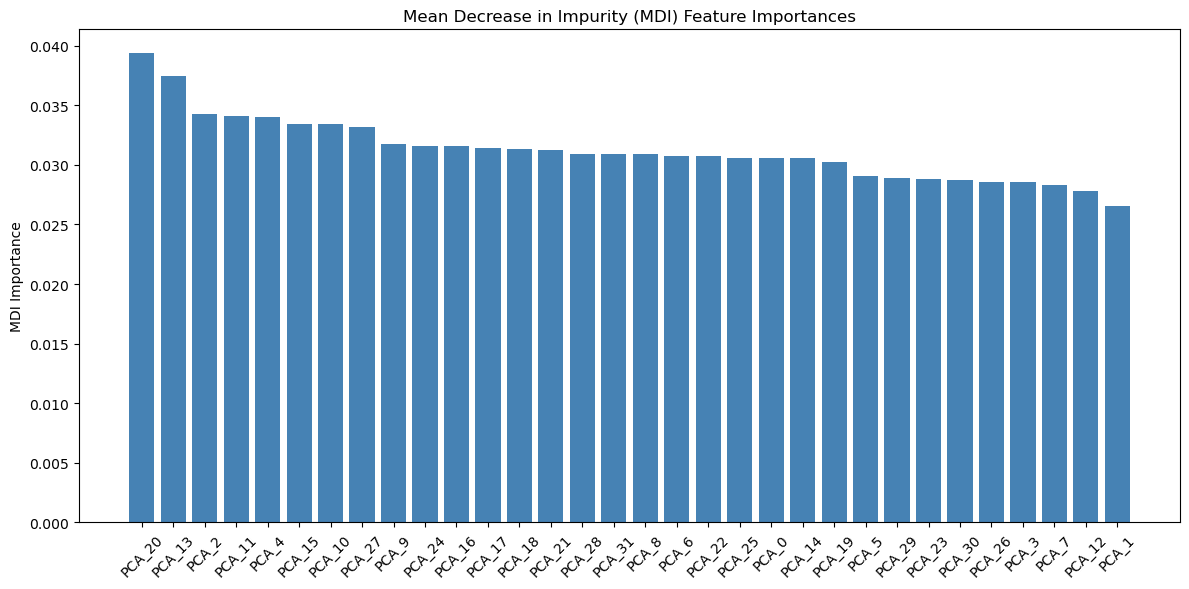

In [11]:
import matplotlib.pyplot as plt


# 1. MDI
RF_fit = RF.fit(X, y, sample_weight=weights)
mdi_imp = feat_imp_mdi(RF_fit, col)
print("Mean Decrease in Impurity (MDI):")
print(mdi_imp)
mdi_imp.to_csv("results/mdi.csv")

mdi_imp = pd.read_csv("results/mdi.csv", index_col=0)
mdi_sorted = mdi_imp.sort_values(by="mean", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(mdi_sorted.index, mdi_sorted["mean"], color="steelblue")
plt.xticks(rotation=45)
plt.ylabel("MDI Importance")
plt.title("Mean Decrease in Impurity (MDI) Feature Importances")
plt.tight_layout()


plt.show()

MDA permuting features: 100%|██████████| 32/32 [19:54<00:00, 37.34s/it]


Mean Decrease Accuracy (MDA):
            mean       std
PCA_20  0.000477  0.000188
PCA_1   0.000378  0.000486
PCA_25  0.000252  0.000449
PCA_16  0.000142  0.000483
PCA_2   0.000085  0.000360
PCA_21  0.000073  0.000335
PCA_28  0.000014  0.000663
PCA_6   0.000013  0.000443
PCA_18 -0.000003  0.000434
PCA_11 -0.000020  0.000551
PCA_12 -0.000038  0.000453
PCA_29 -0.000068  0.000611
PCA_31 -0.000085  0.000689
PCA_17 -0.000119  0.000324
PCA_7  -0.000125  0.000468
PCA_4  -0.000127  0.000276
PCA_24 -0.000158  0.000542
PCA_22 -0.000163  0.000212
PCA_9  -0.000195  0.000556
PCA_23 -0.000205  0.000451
PCA_8  -0.000249  0.000347
PCA_10 -0.000277  0.000569
PCA_5  -0.000278  0.000450
PCA_26 -0.000307  0.000682
PCA_0  -0.000333  0.000280
PCA_13 -0.000340  0.000545
PCA_27 -0.000353  0.000461
PCA_19 -0.000458  0.000475
PCA_15 -0.000459  0.000469
PCA_14 -0.000493  0.000379
PCA_3  -0.000550  0.000529
PCA_30 -0.000696  0.000569


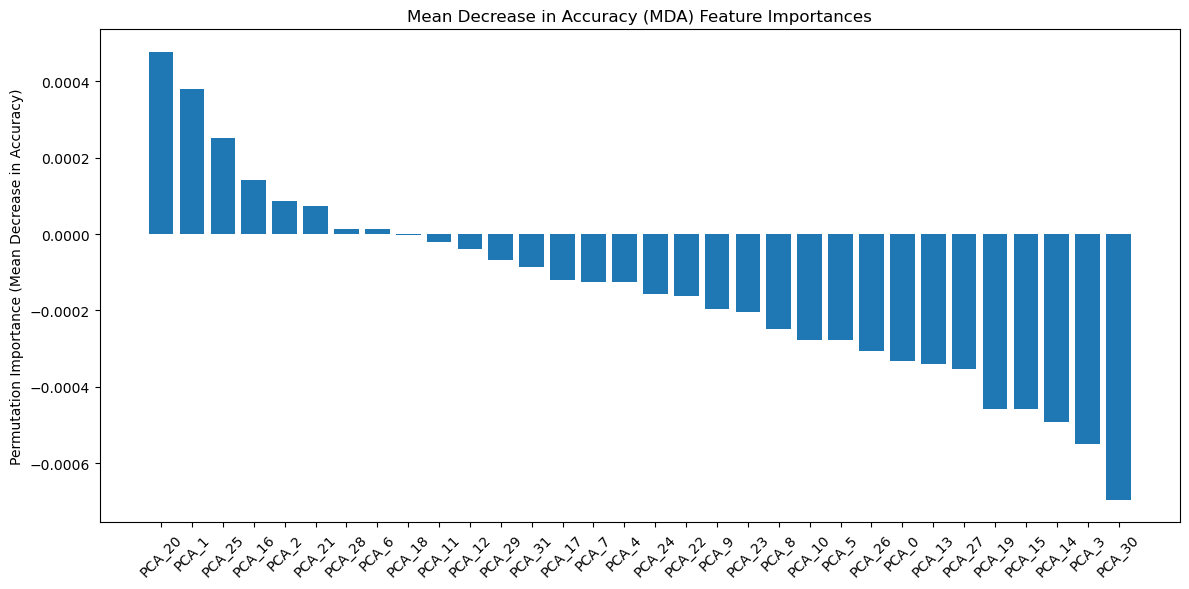

In [12]:
# 2. MDA
mda_imp = feat_imp_mda(
    RF, X, y, cv=5,
    sample_weight=weights,
    t1=t1, pct_embargo=0.01,
    scoring="neg_log_loss"
)
print("Mean Decrease Accuracy (MDA):")
print(mda_imp)
mda_imp.to_csv("results/mda.csv")



mda_imp = pd.read_csv("results/mda.csv", index_col=0)

mda_sorted = mda_imp.sort_values("mean", ascending=False)

# 繪製長條圖並加上標準差誤差線
plt.figure(figsize=(12, 6))
plt.bar(
    mda_sorted.index,
    mda_sorted["mean"],
)
plt.xticks(rotation=45)
plt.ylabel("Permutation Importance (Mean Decrease in Accuracy)")
plt.title("Mean Decrease in Accuracy (MDA) Feature Importances")
plt.tight_layout()

plt.show()

Single Factor Importance (SFI):
            mean       std
PCA_10 -0.693083  0.000117
PCA_12 -0.693499  0.000288
PCA_25 -0.693514  0.000413
PCA_9  -0.693587   0.00032
PCA_11 -0.693672    0.0002
PCA_16 -0.693696  0.000144
PCA_19 -0.693731  0.000149
PCA_27 -0.693749  0.000459
PCA_20 -0.693754  0.000302
PCA_1   -0.69378  0.000474
PCA_2  -0.693808  0.000349
PCA_5  -0.693823  0.000272
PCA_23 -0.693842  0.000082
PCA_8  -0.693852  0.000275
PCA_29 -0.693869  0.000308
PCA_24 -0.693884  0.000274
PCA_26   -0.6939  0.000239
PCA_18 -0.693911  0.000292
PCA_31 -0.693973  0.000401
PCA_15 -0.694006  0.000224
PCA_4  -0.694006  0.000207
PCA_0   -0.69403  0.000522
PCA_22 -0.694054  0.000163
PCA_21 -0.694064   0.00023
PCA_17 -0.694121  0.000447
PCA_13 -0.694122  0.000088
PCA_7   -0.69423  0.000401
PCA_3  -0.694235  0.000193
PCA_6  -0.694261  0.000283
PCA_30 -0.694287  0.000131
PCA_28 -0.694413  0.000114
PCA_14 -0.694521  0.000425


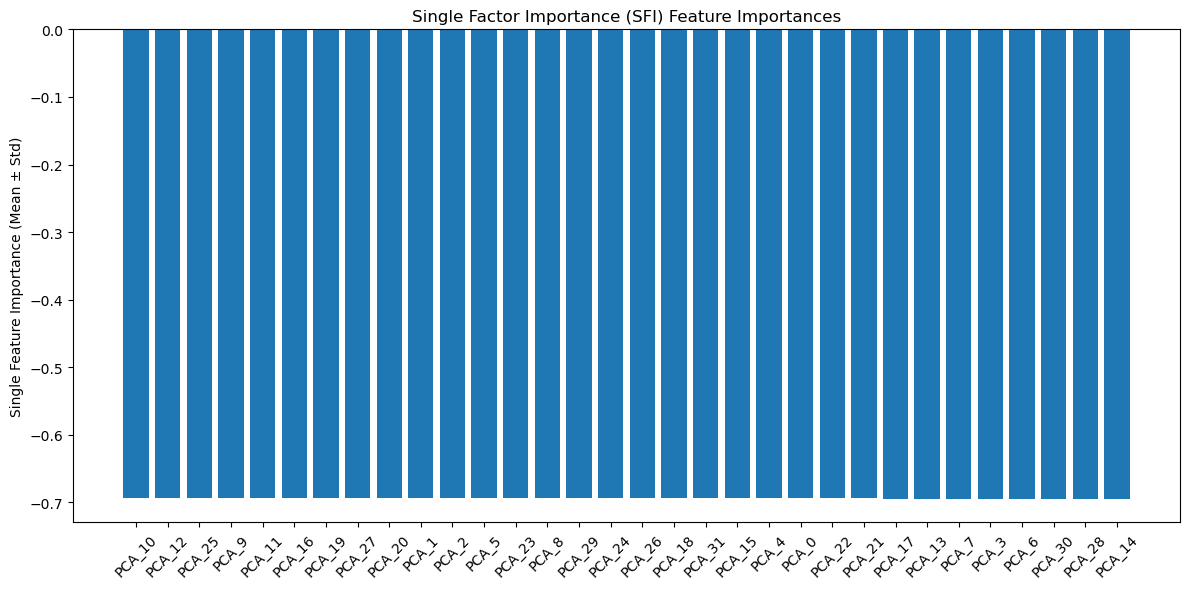

In [13]:
# 3. SFI
sfi_imp = SFI(
    X.columns, RF, X, y, 
    scoring="neg_log_loss", 
    sample_weight=weights , 
    cv=5, t1 = t1, pct_embargo=0.01)
print("Single Factor Importance (SFI):")
print(sfi_imp)
sfi_imp.to_csv("results/sfi.csv")

sfi_imp = pd.read_csv("results/sfi.csv", index_col=0)


sfi_sorted = sfi_imp.sort_values("mean", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(
    sfi_sorted.index,
    sfi_sorted["mean"],
)
plt.xticks(rotation=45)
plt.ylabel("Single Feature Importance (Mean ± Std)")
plt.title("Single Factor Importance (SFI) Feature Importances")
plt.tight_layout()

plt.show()